# Notebook for COMP9517 Group Project (22T2)
**Group**: COMP9517_prodigies  
**Group Members** :  
Zhitong Chen (z5300114)  
Shu Wang (z5211077)  
Yunseok Jang (z5286005)  
Nan Du (z5245818)  
Chenming Yuan (z5355419)

# Make Directories
The structure of our input files is:  
**step_images/test/STEP-ICCV21-01/** and **step_images/test/STEP-ICCV21-07/**. They are testing set from https://motchallenge.net/data/STEP-ICCV21/.  
**txt_files/test_1.txt** and **txt_files/test_2.txt**. They are output of detecting and tracking models.  
  
The structure of our output files is:  
**output/output_images/test_1/** and **output/output_images/test_2/** , they are our output images.  
**output/output_videos/output_test_1.mp4** and **output/output_videos/output_test_2.mp4**, they are our output videos made from output images.  
  
First we need to check if these directories and files are existed, if not, we create them.

In [1]:
import os
import cv2
import matplotlib.pyplot as plt

In [2]:
# define paths
# input files, they should exist
# input images
test_1_img_path = 'step_images/test/STEP-ICCV21-01/'
test_2_img_path = 'step_images/test/STEP-ICCV21-07/'
# input txt files
test_1_txt_path = 'txt_files/test_1.txt'
test_2_txt_path = 'txt_files/test_2.txt '

# output paths
# if they exist, do nothing
# if not, make these directories
# output images
test_1_out_img_path = 'output/output_images/test_1/'
test_2_out_img_path = 'output/output_images/test_2/'
# output videos
out_video_dir = 'output/output_videos/'

In [3]:
# check if there are input files
if (os.path.exists(test_1_img_path) == False):
    print('Input images for test 1 not found.')
if (os.path.exists(test_2_img_path) == False):
    print('Input images for test 2 not found.')
if (os.path.exists(test_1_txt_path) == False): 
    print('Input txt file for test 1 not found.')
if (os.path.exists(test_2_txt_path) == False):
    print('Input txt file for test 2 not found.')

In [4]:
# create output directories
if (os.path.exists(test_1_out_img_path) == False):
    os.makedirs(test_1_out_img_path)
if (os.path.exists(test_2_out_img_path) == False):
    os.makedirs(test_2_out_img_path)
if (os.path.exists(out_video_dir) == False):
    os.makedirs(out_video_dir)

# Preparation - Change input images into videos

The `jpg_to_mp4` function takes a direcotory of images, and change images in it to 

In [5]:
from jpg_to_mp4 import jpg_to_mp4

This is preparation for running the Yolov5+StrongSORT+OSNet model, so we do not need to run this here.

In [6]:
# jpg_to_mp4(test_1_img_path, 'input_test_1.mp4')
# jpg_to_mp4(test_2_img_path, 'input_test_2.mp4')

# Using Yolov5+StrongSORT+OSNet Model
We finally use the pretrained model **yolov5-strongsort-osnet-2022** for our project. (You could find it here: https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet , and the citation in the end of this notebook). We have tried to detect person by background subtraction, it did not work well. We also tried to track persons using output of Yolov5, but since we did not implement the re-identification model, so we will lose a pedestrian once it was not detected in a frame. Finally, we decide to use the **yolov5-strongsort-osnet-2022**  to do both detecting and tracking.   
We firstly used the yolov5s.pt as weights of our model, but it detected too less pedestrains. Then we labeled training sets ourself, and used these labeled images to train the weights ourself, it could detect almost all pedestrains in each frame, but it will detect benches or chairs as pedestrian mistakenly. Finally we decide to use the **crowdhuman_yolov5m.pt** recomended by the author of **yolov5-strongsort-osnet-2022** for yolov5, and **osnet_x0_25_market1501.pt** for strongSORT.  

We will not include codes for **yolov5-strongsort-osnet-2022** in our submission, because we use the output txt file for this, so our code could run without the code of **yolov5-strongsort-osnet-2022**.  
If you want to try to generate the output file yourself, you need first clone the git repository, and download the **crowdhuman_yolov5m.pt** from https://drive.google.com/file/d/1gglIwqxaH2iTvy6lZlXuAcMpd_U0GCUb/view?usp=sharing , and put this into the **weights** directory in the **yolov5** directory. Then run `python track.py --source test_1.mp4 --yolo-weights yolov5/weights/crowdhuman_yolov5m.pt --strong-sort-weights osnet_x0_25_market1501.pt --classes 0 --save-txt`. You could do this to test 2 video as well by changing the video after `--source` into `test_2.mp4`. Test videos could be generated by using `jpg_to_mp4` function in `jpg_to_mp4.py` (you could just uncomment codes in the cell above, this will give you videos for test 1 and test 2. 

# Our implementation
There are 3 tasks. We implement all 3 tasks together, but we set a flag to run each task seperately.  
`flag='task_1'` for only showing results for task 1. i.e. only draw boxes and trajectories.  
`flag='task_2'` for only showing results for task 2. i.e. only display number of persons, and show number of persons in the rectangular region drawn by user, now boxes and trajectories.   
`flag='task_3'` for only showing results for task 3. i.e. only display group analysis result, no boxes for single pedestrians. This makes the output image not that messy.  
`flag='task_1_and_2` conbines output of task_1 and task_2.  
`flag='task_1_and_3` conbines output of task_1 and task_3.  
`flag='all'` display results for all 3 tasks.

In [6]:
# first import our functions
from object_tracking import detect_and_tracks, view, count_person_and_compare

**`detect_and_tracks(txt_path, input_img_path, output_img_path, flag)`** :    
This function uses the txt output from yolov5-strongsort-osnet-2022 model to draw boxes and trajectories, count number of persons, and do group analysis on images, and output result images to the output_iamges directory.  
It returns `all_label`, `n_person`, and `id_tracks`.   
`all_label` is a 3D array, it records number of persons in each frame detected by the yolov5-strongsort-osnet-2022 model. The first dimension is frame, the second dimension is a list of lists of information for each pedestrians detected in this frame, and the third dimension is a list of information (\[center_x, center_y, width, height\]) for a pedestrian.   
`n_person` is a list of number of pedestrians in each frame. Its lenghth equals to number of frames, so we could use index of frame to get the number of pedestrians in this frame.  
`id_trackes` is a 3D array. The first dimension is ids of pedestrians, the second dimension is frames, and the third dimension is the center_x, center_y, width, and height for this pedestrian in this frame. i.e. id_tracks\[i\]\[j\] = \[center_x, center_y, width, height\] of pedestrian with id = i in frame j.   

**`view(output_img_path, id_tracks, flag)`** :  
This function helps us to view output images from `detect_and_tracks`. If the flag is 'task_2', or 'task_1_and_2', or 'all', we could draw rectangular by mouse in the view window.  

**`count_person_and_compare(all_label, n_person, csv_path)`** :  
This function will make a csv file to compare numbers of pedestrians detected by the model and number of pedestrians after filling gaps. This function is not required by the project specification. I wrote this to show the performance of my fill gap function.

## Task 1:
In this task, we draw boxes and trajectories for each pedestrian in each frames.

### Detect and Track for Task 1
We do this for both test 1 and test 2. 

In [24]:
# detect and track pedestrians

all_label_1, n_person_1, id_tracks_1 = detect_and_tracks(test_1_txt_path, test_1_img_path, test_1_out_img_path, flag='task_1')
print("Finish making output images for test 1\n")
all_label_2, n_person_2, id_tracks_2 = detect_and_tracks(test_2_txt_path, test_2_img_path, test_2_out_img_path, flag='task_1')
print("Finish making output images for test 2")

Finish making frame 50/450
Finish making frame 100/450
Finish making frame 150/450
Finish making frame 200/450
Finish making frame 250/450
Finish making frame 300/450
Finish making frame 350/450
Finish making frame 400/450
Finish making frame 450/450
Finish making output images for test 1

Finish making frame 50/500
Finish making frame 100/500
Finish making frame 150/500
Finish making frame 200/500
Finish making frame 250/500
Finish making frame 300/500
Finish making frame 350/500
Finish making frame 400/500
Finish making frame 450/500
Finish making frame 500/500
Finish making output images for test 2


### View Output for this task
First view test 1.

In [25]:
view(test_1_out_img_path, id_tracks_1, flag='task_1')

Then view test 2, if you want to. Actually, our codes perform better on test 2.

In [26]:
view(test_2_out_img_path, id_tracks_2, flag='task_1')

### Store Output of Task 1 as Video (optional) 
Since the output images will be overwritten after running these functions for task 2. Therefore, if you want to keep the result of task 1, you could make a video for them and store the video. I overwrite these images because they are just intermediate results.

In [27]:
# define paths
task_1_test_1_video_path = out_video_dir + 'task_1_test_1.mp4'
task_1_test_2_video_path = out_video_dir + 'task_1_test_2.mp4'

# make videos by jpg_to_mp4 function
jpg_to_mp4(test_1_out_img_path, task_1_test_1_video_path)
print('Finish making video for test 1.')
jpg_to_mp4(test_2_out_img_path, task_1_test_2_video_path)
print('Finish making video for test 2.')

Finish making video for test 1.
Finish making video for test 2.


### Display One Output Image for Task 1
Let's display one output image here.

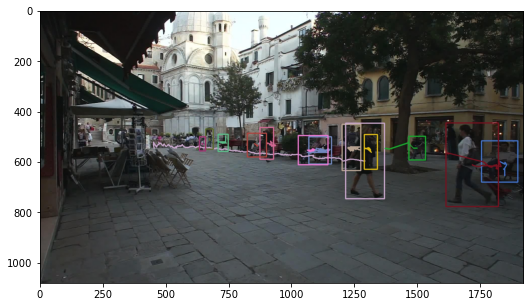

In [35]:
jpg_list = os.listdir(test_1_out_img_path)
img1 = cv2.imread(test_1_out_img_path + jpg_list[-50])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.imshow(img1)

## Task 2:
In this task, we count total number of unique pedestrians till current frame, and number of pedestrians in current frame, and put these numbers in the top right corner of output images.  
The view function will allow user to draw a rectangular in the video window and display the number of pedestrians in this rectangular.  
I want to see boxes and trajectories so I use `flag='task_1_and_2'`. If you only want to see result of task 2, you could use `flag='task_2'` . 

Details of how we implement task 2.3 and task 2.4 is shown in `video_crop.py`.

### Detect and Track for Task 1 and 2
We do this for both test 1 and test 2. 

In [9]:
# detect and track pedestrians

all_label_1, n_person_1, id_tracks_1 = detect_and_tracks(test_1_txt_path, test_1_img_path, test_1_out_img_path, flag='task_1_and_2')
print("Finish making output images for test 1\n")
all_label_2, n_person_2, id_tracks_2 = detect_and_tracks(test_2_txt_path, test_2_img_path, test_2_out_img_path, flag='task_1_and_2')
print("Finish making output images for test 2")

Finish making frame 50/450
Finish making frame 100/450
Finish making frame 150/450
Finish making frame 200/450
Finish making frame 250/450
Finish making frame 300/450
Finish making frame 350/450
Finish making frame 400/450
Finish making frame 450/450
Finish making output images for test 1

Finish making frame 50/500
Finish making frame 100/500
Finish making frame 150/500
Finish making frame 200/500
Finish making frame 250/500
Finish making frame 300/500
Finish making frame 350/500
Finish making frame 400/500
Finish making frame 450/500
Finish making frame 500/500
Finish making output images for test 2


### View Output for Task 1 and 2
Do not forget you could draw rectangular in the video window. \
NOTE: It might sometimes cause an error. In this case, please re-run the following functions.

In [10]:
view(test_1_out_img_path, id_tracks_1, flag='task_2')

Then view test 2, if you want to. Actually, our codes perform better on test 2.

In [11]:
view(test_2_out_img_path, id_tracks_2, flag='task_2')

### Store Output of Task 1 and 2 as Video (optional) 
Since the output images will be overwritten after running these functions for task 3. Therefore, if you want to keep the result of task 1 and 2, you could make a video for them and store the video. I overwrite these images because they are just intermediate results.

In [39]:
# define paths
task_1_and_2_test_1_video_path = out_video_dir + 'task_1_and_2_test_1.mp4'
task_1_and_2_test_2_video_path = out_video_dir + 'task_1_and_2_test_2.mp4'

# make videos by jpg_to_mp4 function
jpg_to_mp4(test_1_out_img_path, task_1_and_2_test_1_video_path)
print('Finish making video for test 1.')
jpg_to_mp4(test_2_out_img_path, task_1_and_2_test_2_video_path)
print('Finish making video for test 2.')

Finish making video for test 1.
Finish making video for test 2.


### Display One Output Image for Task 1 and 2
Let's display one output image here to record what we have done.  
As you could see, there are number of pedestrians in the top right corner of the image.

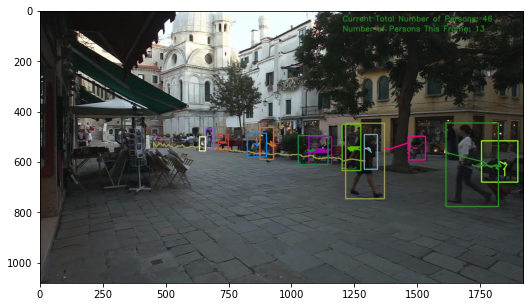

In [42]:
jpg_list = os.listdir(test_1_out_img_path)
img2 = cv2.imread(test_1_out_img_path + jpg_list[-50])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.imshow(img2)

## Task 3:
In this task, use red box to show a group. 
In task 3.1, we count number of pedestrians walk in groups and walk alone and show these in the top right corner of the image.   
In task 3.2, we show group formation and group destrunction by saying `HELLO!` when the pedestrian joins a group, and saying `BYE!` when the pedestrian leaves the group.   
In task 3.3, we show a pedestrian is entering the scene by saying `CHEESE`, and show a pedestrian is leaving the scene by saying `CYALL`.    
We draw viewers' attention by these words and thicker boxes.   
We choose `flag='task_3'` to avoid getting messy images.  
Details of how we implement task 3 is shown in `analyses.py`.

### Detect and Track for Task 3
We do this for both test 1 and test 2. 

In [7]:
# detect and track pedestrians
all_label_1, n_person_1, id_tracks_1 = detect_and_tracks(test_1_txt_path, test_1_img_path, test_1_out_img_path, flag='task_3')
print("Finish making output images for test 1\n")
all_label_2, n_person_2, id_tracks_2 = detect_and_tracks(test_2_txt_path, test_2_img_path, test_2_out_img_path, flag='task_3')
print("Finish making output images for test 2")

Finish making frame 50/450
Finish making frame 100/450
Finish making frame 150/450
Finish making frame 200/450
Finish making frame 250/450
Finish making frame 300/450
Finish making frame 350/450
Finish making frame 400/450
Finish making frame 450/450
Finish making output images for test 1

Finish making frame 50/500
Finish making frame 100/500
Finish making frame 150/500
Finish making frame 200/500
Finish making frame 250/500
Finish making frame 300/500
Finish making frame 350/500
Finish making frame 400/500
Finish making frame 450/500
Finish making frame 500/500
Finish making output images for test 2


### View Output for Task 3

In [9]:
view(test_1_out_img_path, id_tracks_1, flag='task_3')

Then view test 2, if you want to. Actually, our codes perform better on test 2.

In [10]:
view(test_2_out_img_path, id_tracks_2, flag='task_3')

### Store Output of Task 3 as Video (optional) 
Since the output images will be overwritten after running these functions for the whole project. Therefore, if you want to keep the result of task 3, you could make a video for them and store the video. I overwrite these images because they are just intermediate results.

In [11]:
# define paths
task_3_test_1_video_path = out_video_dir + 'task_3_test_1.mp4'
task_3_test_2_video_path = out_video_dir + 'task_3_test_2.mp4'

# make videos by jpg_to_mp4 function
jpg_to_mp4(test_1_out_img_path, task_3_test_1_video_path)
print('Finish making video for test 1.')
jpg_to_mp4(test_2_out_img_path, task_3_test_2_video_path)
print('Finish making video for test 2.')

Finish making video for test 1.
Finish making video for test 2.


### Display One Output Image for Task 3
Let's display one output image here to record what we have done for task 3.  
As you could see, there are number of pedestrians walk in group and walk alone in the top right corner of the image.

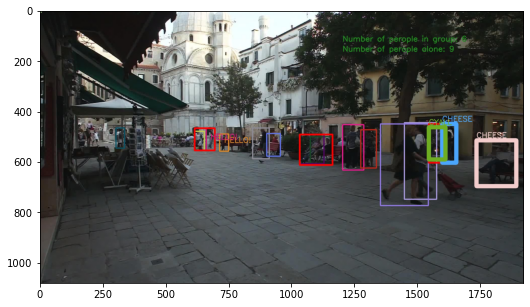

In [8]:
jpg_list = os.listdir(test_1_out_img_path)
img3 = cv2.imread(test_1_out_img_path + jpg_list[-30])
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5))
plt.imshow(img3)

# Result for the Whole Project
Now combiane result for task 1, task 2, and task 3 together. This is the final output of out project. This looks very messy. 

### Detect and Track
We do this for both test 1 and test 2. 

In [12]:
# detect and track pedestrians
all_label_1, n_person_1, id_tracks_1 = detect_and_tracks(test_1_txt_path, test_1_img_path, test_1_out_img_path, flag='all')
print("Finish making output images for test 1\n")
all_label_2, n_person_2, id_tracks_2 = detect_and_tracks(test_2_txt_path, test_2_img_path, test_2_out_img_path, flag='all')
print("Finish making output images for test 2")

Finish making frame 50/450
Finish making frame 100/450
Finish making frame 150/450
Finish making frame 200/450
Finish making frame 250/450
Finish making frame 300/450
Finish making frame 350/450
Finish making frame 400/450
Finish making frame 450/450
Finish making output images for test 1

Finish making frame 50/500
Finish making frame 100/500
Finish making frame 150/500
Finish making frame 200/500
Finish making frame 250/500
Finish making frame 300/500
Finish making frame 350/500
Finish making frame 400/500
Finish making frame 450/500
Finish making frame 500/500
Finish making output images for test 2


### View Final Output
Do not forget you could draw rectangular in the video window.

In [13]:
view(test_1_out_img_path, id_tracks_1, flag='all')

Then view test 2, if you want to. Actually, our codes perform better on test 2.

In [14]:
view(test_2_out_img_path, id_tracks_2, flag='all')

### Store final Output (optional) 
You could store the output images as a video.

In [15]:
# define paths
test_1_video_path = out_video_dir + 'output_test_1.mp4'
test_2_video_path = out_video_dir + 'output_test_2.mp4'

# make videos by jpg_to_mp4 function
jpg_to_mp4(test_1_out_img_path, test_1_video_path)
print('Finish making video for test 1.')
jpg_to_mp4(test_2_out_img_path, test_2_video_path)
print('Finish making video for test 2.')

Finish making video for test 1.
Finish making video for test 2.


### Display One Output Image for Final Output
Let's display one output image here to record what we have done for the whole project.  
You could see boxes and trajectories for task 1; number of unique pedestrians till now, and number of pedestrians in this frame for task 2; number of pedestrians in this frame, and number of pedestrians walk in group and walk alone for task 3.1, group formation and destruction by saying `HELLO!` or `BYE!` for task 3.1, and entering and leaving scene by saying `CHEESE` and `CYALL`, and also highlighting by much thicker boxes for task 3.3. 

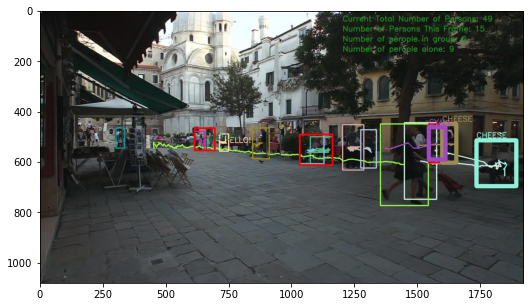

In [16]:
jpg_list = os.listdir(test_1_out_img_path)
img_all = cv2.imread(test_1_out_img_path + jpg_list[-30])
img_all = cv2.cvtColor(img_all, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 5)
plt.imshow(img_all)

# Evaluation and Discussion
Since we do not have labels for test videos, so we use qualitative evaluation here.  

## Improvements Made by Filling Gaps
We wrote codes to fill gaps in frames. Filling gaps reduced the influence brought by obstructions and does increase number detected in each frame. I have wrote a function to store number of pedestrian detect by model and number of pedestrians in each frame after filling gaps, so let us run this function and read these csv files to get data we need.  

In [25]:
txt_out_dir = 'output/output_csv/'

if (os.path.exists(txt_out_dir) == False):
    os.makedirs(txt_out_dir)
    
test_1_csv_path = txt_out_dir + 'test_1.csv'
test_2_csv_path = txt_out_dir + 'test_2.csv'

# write to csv files
count_person_and_compare(all_label_1, n_person_1, test_1_csv_path)
print("Finish making output csv file for test 1")
count_person_and_compare(all_label_2, n_person_2, test_2_csv_path)
print("Finish making output csv file for test 2")

Finish making output csv file for test 1
Finish making output csv file for test 2


Then read them.

In [37]:
import pandas as pd 
import numpy as np
# read csv
df1 = pd.read_csv(test_1_csv_path)
df2 = pd.read_csv(test_2_csv_path)

test_1_before = df1['original']# number of pedestrians detected by model
test_1_after = df1['after fill gaps']# number of pedestrians after filling gaps
test_1_diff = df1['difference']# improvement made by fill gaps

test_2_before = df2['original']
test_2_after = df2['after fill gaps']
test_2_diff = df2['difference']

print('=========== Test 1 ================')
print(f'Average number of pedestrians detected each frame: {round(np.mean(test_1_before), 3)}')
print(f'Average number of pedestrians in each frame after filling gaps: {round(np.mean(test_1_after), 3)}')
print(f'Average number of pedestrians increased by filling gaps: {round(np.mean(test_1_diff), 3)}')
print(f'Maximum number of pedestrians increased by filling gaps: {np.max(test_1_diff)}')

print('\n=========== Test 2 ================')
print(f'Average number of pedestrians detected each frame: {round(np.mean(test_2_before), 3)}')
print(f'Average number of pedestrians in each frame after filling gaps: {round(np.mean(test_2_after), 3)}')
print(f'Average number of pedestrians increased by filling gaps: {round(np.mean(test_2_diff), 3)}')
print(f'Maximum number of pedestrians increased by filling gaps: {np.max(test_2_diff)}')

=========== Test 1 ================
Average number of pedestrians detected each frame: 12.011
Average number of pedestrians in each frame after filling gaps: 14.649
Average number of pedestrians increased by filling gaps: 2.638
Maximum number of pedestrians increased by filling gaps: 8

=========== Test 2 ================
Average number of pedestrians detected each frame: 23.13
Average number of pedestrians in each frame after filling gaps: 25.912
Average number of pedestrians increased by filling gaps: 2.782
Maximum number of pedestrians increased by filling gaps: 8


#### Make Plots to Show the Improvement

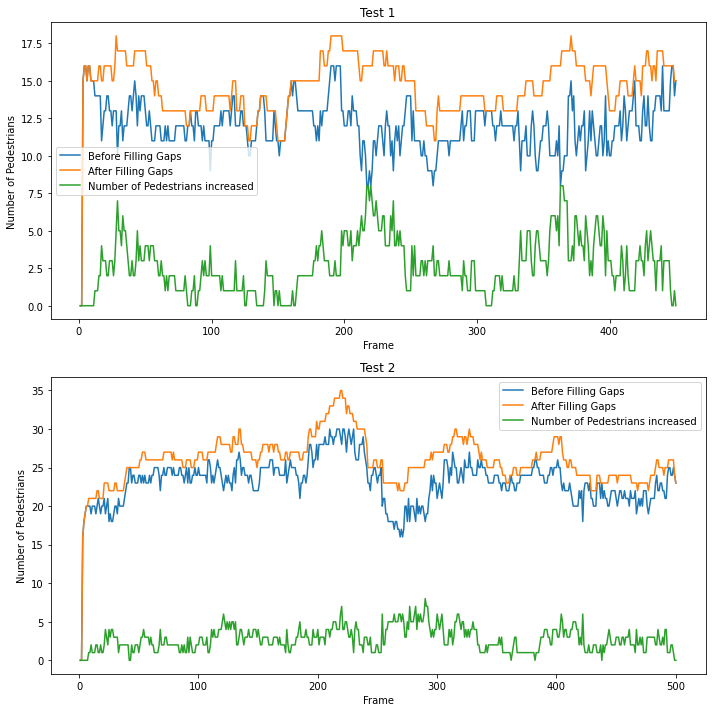

In [42]:
# plot accuracy
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(range(1, len(test_1_before) + 1), test_1_before, label = "Before Filling Gaps")
plt.plot(range(1, len(test_1_after) + 1), test_1_after, label = "After Filling Gaps")
plt.plot(range(1, len(test_1_diff) + 1), test_1_diff, label = "Number of Pedestrians increased")
plt.xlabel('Frame')
plt.ylabel('Number of Pedestrians')
plt.legend()
plt.title('Test 1')

# plot loss
plt.subplot(2, 1, 2)
plt.plot(range(1, len(test_2_before) + 1), test_2_before, label = "Before Filling Gaps")
plt.plot(range(1, len(test_2_after) + 1), test_2_after, label = "After Filling Gaps")
plt.plot(range(1, len(test_2_diff) + 1), test_2_diff, label = "Number of Pedestrians increased")
plt.xlabel('Frame')
plt.ylabel('Number of Pedestrians')
plt.legend()
plt.title('Test 2')

plt.tight_layout()
plt.show()

As we could see from plots above, filling gaps does increased the number of pedestrians detected in each frame a lot. 

## The Percentage of Pedestrians Detected
First, we use random number to choose 3 frames in each test set, count number of pedestrians in each of these frames by ourself, and compare them with the number of pedestrians detected by the model. 

In [17]:
import random 
# Please do NOT run this again, because this will generate different random numbers
# print(f'Frames choosen for test 1 are {random.randint(1, 450)}, {random.randint(1, 450)}, and {random.randint(1, 450)}' )
# print(f'Frames choosen for test 2 are {random.randint(1, 500)}, {random.randint(1, 500)}, and {random.randint(1, 500)}' )

Frames choosen for test 1 are 282, 219, and 259
Frames choosen for test 2 are 478, 445, and 236


Now I label pedestrians in these 6 frames mannaly, and put them into the directory **count_images**. I use outputs from task 1 and 2 to compare, because after added groups, the output images are too messy to see each boxes clearly. 

#### Test 1:

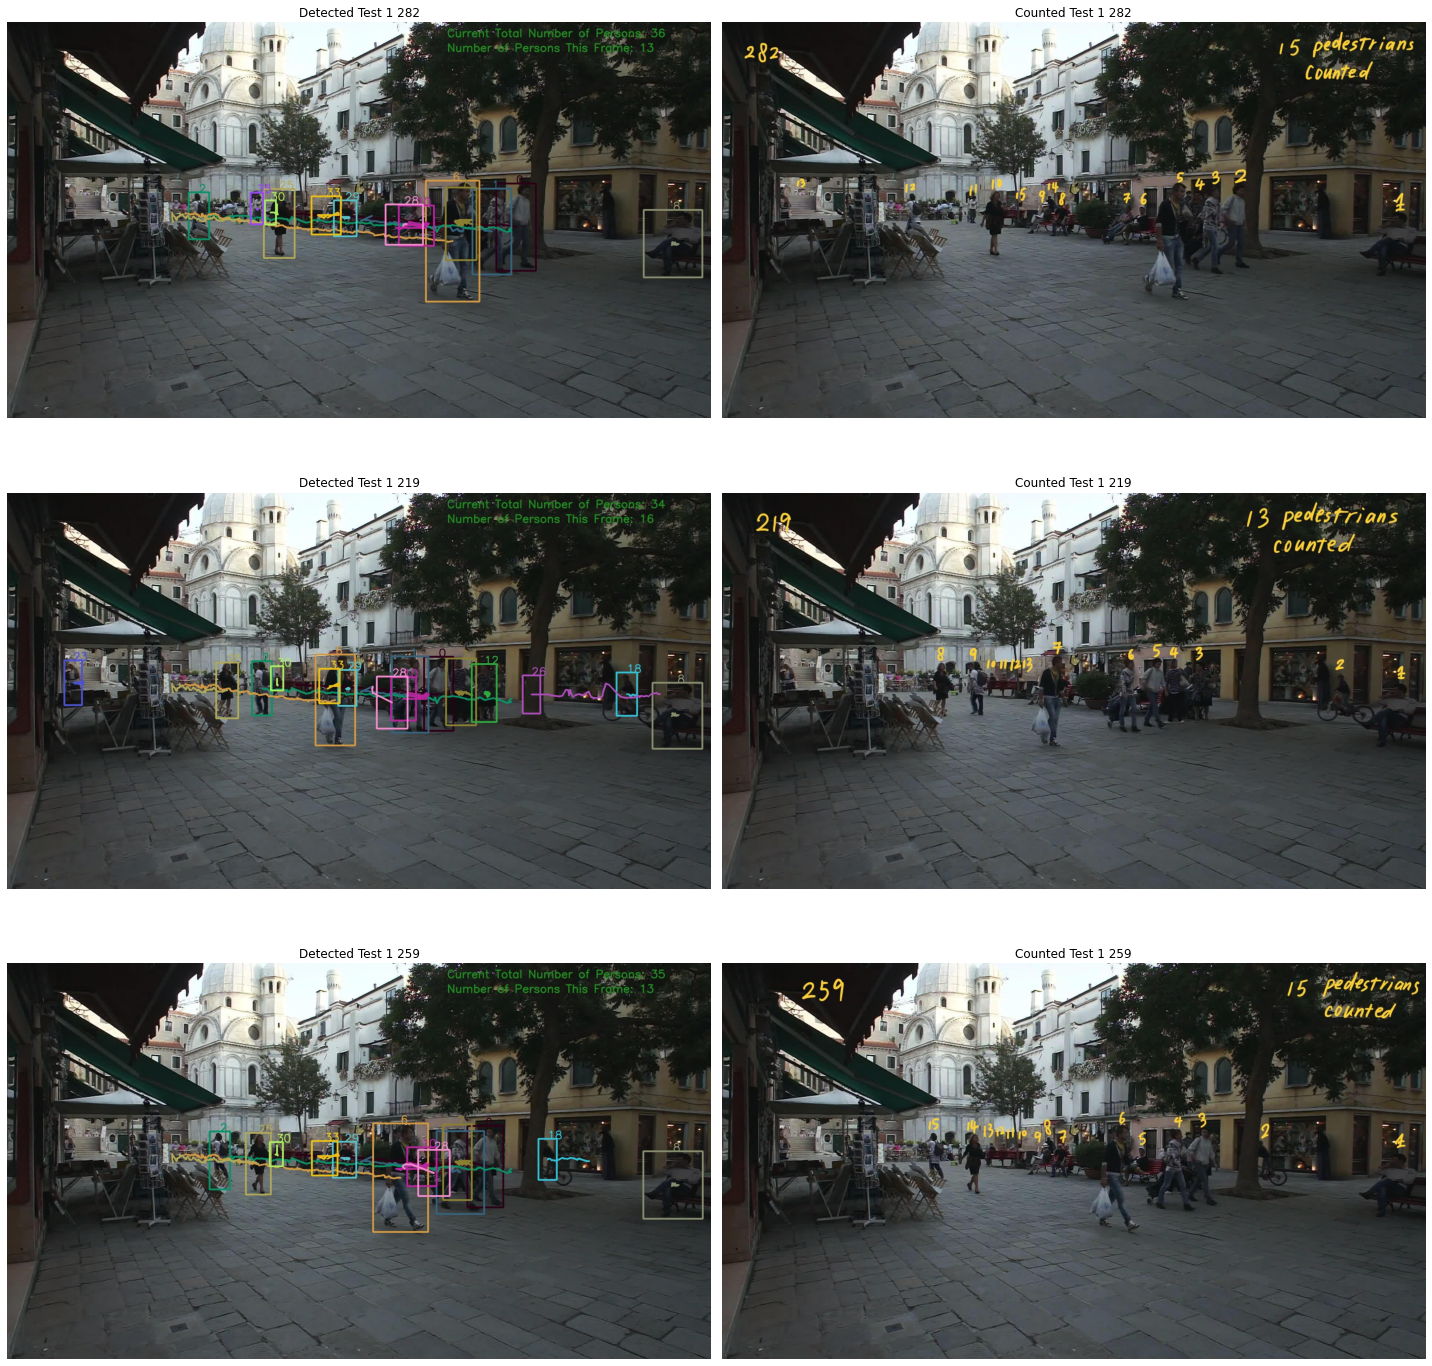

In [22]:
count_path = 'count_images/'

titles = ['Detected Test 1 282', 'Counted Test 1 282', 
          'Detected Test 1 219', 'Counted Test 1 219', 
          'Detected Test 1 259', 'Counted Test 1 259']
imgs = [count_path + 'test_1_detect_282.jpg', count_path + 'test_1_count_282.jpg',
        count_path + 'test_1_detect_219.jpg', count_path + 'test_1_count_219.jpg', 
        count_path + 'test_1_detect_259.jpg', count_path + 'test_1_count_259.jpg']

fig = plt.figure(figsize=(20, 20))
for i in range(len(titles)):
    ax = fig.add_subplot(3, 2, i+1)
        
    img = cv2.imread(imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(titles[i])
    ax.set_axis_off()
plt.tight_layout()

### Discussion of the Detecting Performance for Test 1
From the figure above, we could see that in both frame 282 and frame 259, 15 pedestrians was counted and 13 pedestrians was counted. In frame 219, 13 pedestrians was counted but 16 pedestrians was detected.   
In average, 14.3 pedestrains was counted and 14 pedestrians was detected, so 97.9% of pedestrians was detected by our software.  
However, the reason why there are 16 pedestrians was detected in frame 219 is pedestrian No.23 is not a pedestrian but was detected as a pedestrian, and the box of pedestrian No.26 is drawn by filling gaps.  
I think the problem that pedestrian No.23 is detected as a person mistakenly is reasonable, because it really looks like a person.  
The problem that the box of pedestrian No.26 is drawn by filling gaps is also reasonable, because we could not see this pedestrian in this frame because he/she is covered by a tree temporarily, but he/she is detected in frames before and after this frame.  
Pedestrians in frame 282 and 259 that are counted but not detected are very far from the camera and covered by other pedestrian or benches or other things. We could identify them as persons by our knownledegs and experiences, but it is hard for models to identify a person by just part of his/her body. If the model does so, it might make more mis-identification problems. 

#### Test 2:

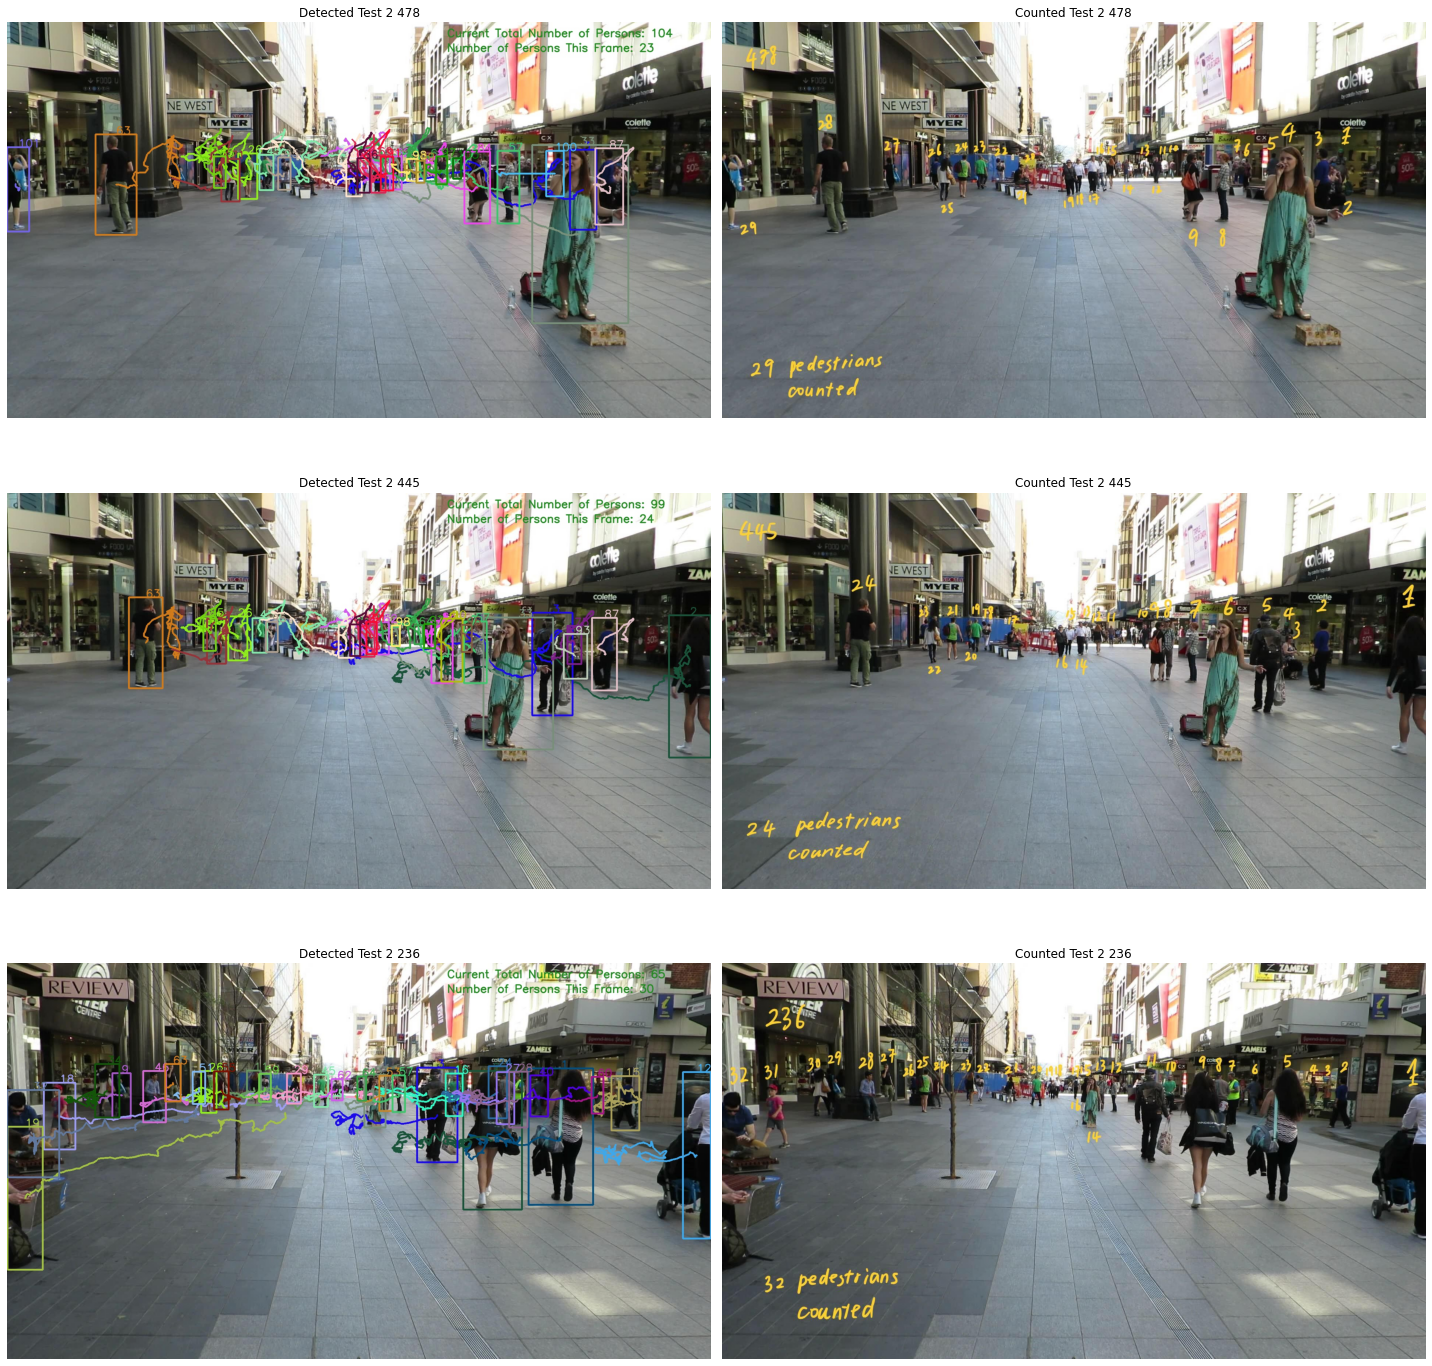

In [23]:
count_path = 'count_images/'

titles = ['Detected Test 2 478', 'Counted Test 2 478', 
          'Detected Test 2 445', 'Counted Test 2 445', 
          'Detected Test 2 236', 'Counted Test 2 236']
imgs = [count_path + 'test_2_detect_478.jpg', count_path + 'test_2_count_478.jpg',
        count_path + 'test_2_detect_445.jpg', count_path + 'test_2_count_445.jpg', 
        count_path + 'test_2_detect_236.jpg', count_path + 'test_2_count_236.jpg']

fig = plt.figure(figsize=(20, 20))
for i in range(len(titles)):
    ax = fig.add_subplot(3, 2, i+1)
        
    img = cv2.imread(imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title(titles[i])
    ax.set_axis_off()
plt.tight_layout()

### Discussion of the Detecting Performance for Test 2
From the figure above, we could see that in frame 478 and frame 236, there are less pedestrians detected than counted. In frame 445, numbers of pedestrians detected and counted are exactly the same.   
In average, 28.3 pedestrains was counted and 25.7 pedestrians was detected, so 90.8% of pedestrians was detected by our software.  
From images above, we could see that this models works really well, because it detected many pedestrians in the image, and it could detect pedestrians that are very far from the camera. The reason why it detected less percentage of pedestrians in test 2 than test 1 might be that I counted pedestrians that are too far from the camera.   

# Citation of the open-source code we used  
**yolov5-strongsort-osnet-2022:**  
Mikel Broström, "Real-time multi-camera multi-object tracker using YOLOv5 and StrongSORT with OSNet", 2022.  
Available: https://github.com/mikel-brostrom/Yolov5_StrongSORT_OSNet  \
\
**Video cropping**\
Adrian Rosebrock 2015, pyimagesearch, accessed 21 July 2022.\
Available: <https://pyimagesearch.com/2015/03/09/capturing-mouse-click-events-with-python-and-opencv/> 